# basic u/v plots from zarr data
# rotates u/v such as to represent zonal and meridional velocities

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(5)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.110:55235 Dashboard: http://10.148.0.110:8787/status,Cluster Workers: 6 Cores: 24 Memory: 150.00 GB


---

# 0: load path


In [6]:
V = ['SSU', 'SSV']
#
D = [xr.open_zarr(scratch+'/mit/standard/%s.zarr'%v) for v in V]
D.append(xr.open_zarr(scratch+'mit/grid.zarr'))
#
ds = xr.merge(D)
#
ds = ds.isel(time=0)
sli = slice(0,None,4) # required to make worldwide plots, otherwise, half the globe is plotted
ds = ds.isel(i=sli, j=sli, i_g=sli, j_g=sli)
#
ds = ds.drop('dtime') # tmp leads to serialization issue at plots
#
ds.persist()
#
print(ds)
print('\n dataset size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
    dxC      (face, j, i_g) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 108, 108)>
    dyG      (face, j, i_g) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 108, 108)>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    rAw      (face, j, i_g) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 108, 108)>
    time     float64 5.702e+06
    dxG      (face, j_g, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 108, 108)>
    dyC      (face, j_g, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 108, 108)>
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j_g      (j_g) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4

--- 

# 1: plot non rotated currents 

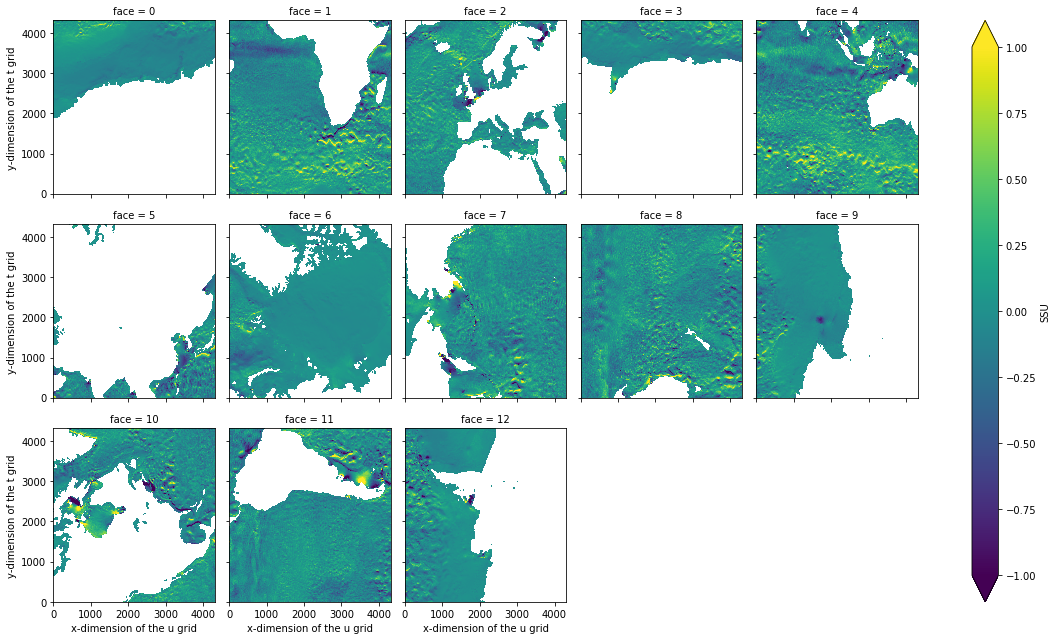

In [7]:
ds.SSU.plot(col='face', col_wrap=5, vmin=-1., vmax=1.)

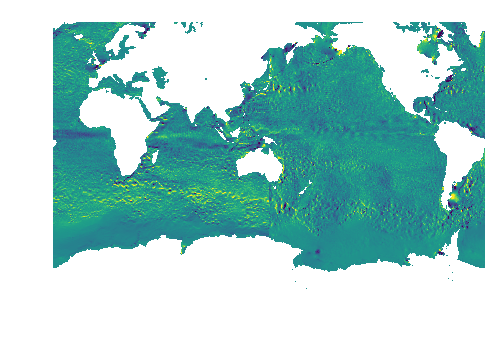

In [8]:
quick_llc_plot(ds.SSU, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

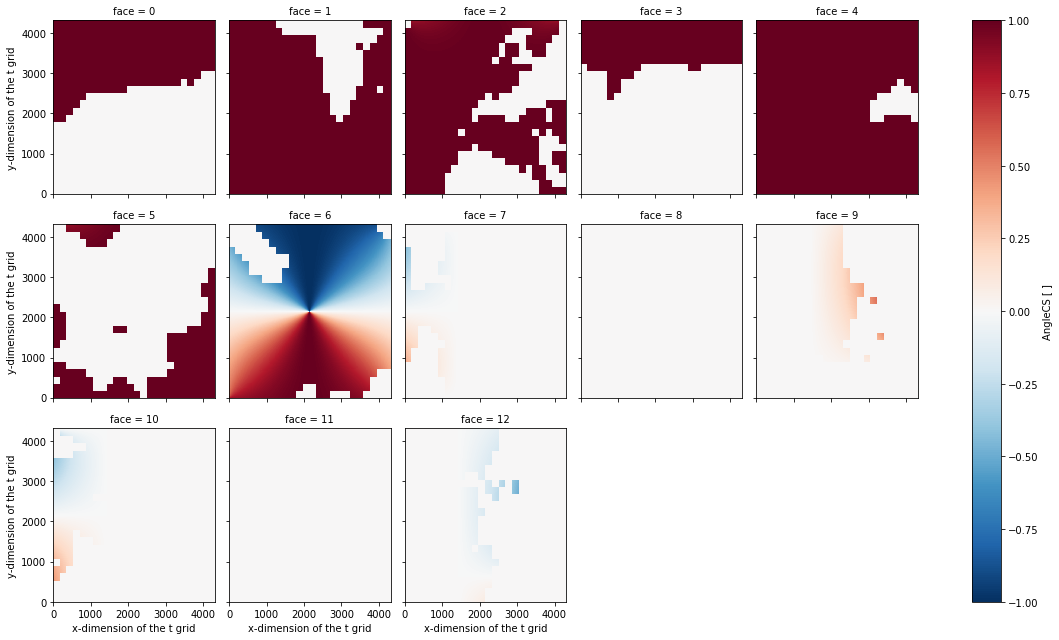

In [9]:
ds.CS.plot(col='face', col_wrap=5)

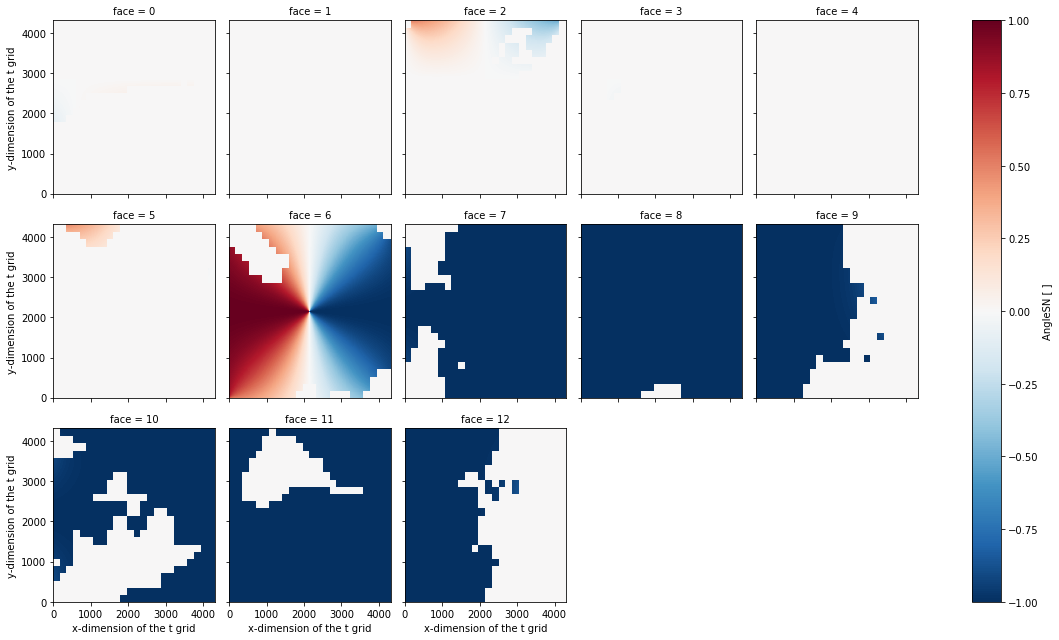

In [10]:
ds.SN.plot(col='face', col_wrap=5)

---

## compute and plot rotated currents


In [11]:
# should do proper grid interpolation instead of renaming
U =  ds.SSU.rename({'i_g': 'i'})*ds.CS - ds.SSV.rename({'j_g': 'j'})*ds.SN
V =  ds.SSU.rename({'i_g': 'i'})*ds.SN + ds.SSV.rename({'j_g': 'j'})*ds.CS
U.persist()
V.persist()

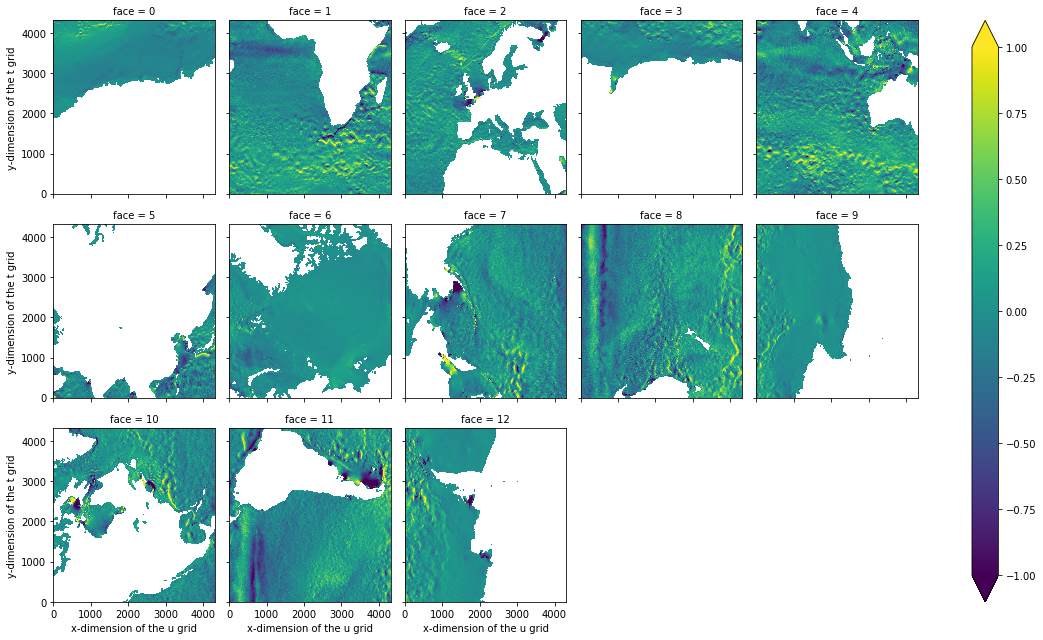

In [12]:
U.plot(col='face', col_wrap=5, vmin=-1., vmax=1.)

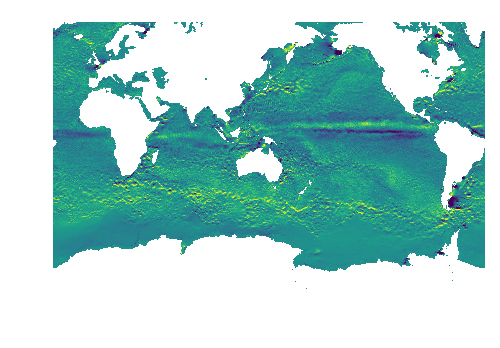

In [13]:
quick_llc_plot(U, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

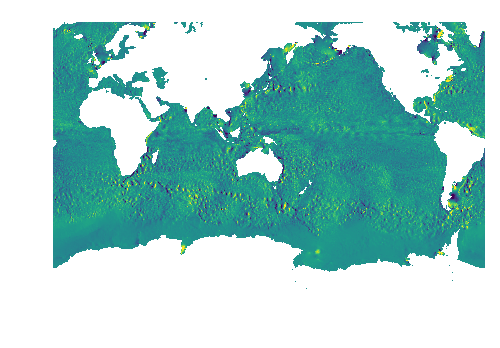

In [14]:
quick_llc_plot(V, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

---

In [27]:
# add workers
w = cluster.scale_up(10)

In [15]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:347]>

In [ ]:
# restart workers
client.restart()

In [ ]:
client